# Kickstarter: Classification
Tests Include:
-KNN
-Logistic Regression
-Decision Trees
-Random Forest
-SVM
-Gradient Boosting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sqlalchemy
from sqlalchemy import create_engine
from flask_sqlalchemy import SQLAlchemy

from sklearn import naive_bayes
from sklearn.naive_bayes import GaussianNB, BernoulliNB,MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve, auc
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import train_test_split, cross_val_predict
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import label_binarize, scale, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder

import warnings
import os
%matplotlib inline

warnings.filterwarnings("ignore") #, category=DeprecationWarning)

/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
# env variable at tensorflow1.4 per https://conda.io/docs/user-guide/tasks/manage-environments.html#saving-environment-variables
# and https://vsupalov.com/flask-sqlalchemy-postgres/

def get_env_variable(name):
    try:
        return os.environ[name]
    except KeyError:
        message = "Expected environment variable '{}' not set.".format(name)
        raise Exception(message)

# the values of those depend on your setup
POSTGRES_URL = get_env_variable("POSTGRES_URL")
POSTGRES_USER = get_env_variable("POSTGRES_USER")
POSTGRES_PW = get_env_variable("POSTGRES_PW")
POSTGRES_DB = get_env_variable("POSTGRES_DB")

In [3]:
DB_URL = 'postgresql+psycopg2://{user}:{pw}@{url}/{db}'.format(user=POSTGRES_USER,pw=POSTGRES_PW,url=POSTGRES_URL,db=POSTGRES_DB)

In [4]:
engine_var = DB_URL
engine = create_engine(engine_var)

In [5]:
# df = pd.read_pickle('data/kickstarter_data.pkl')
df = pd.read_sql_query('''SELECT * FROM kickstarter_data''',engine)
print(df.shape)
pd.read_sql_query('''SELECT state, main_category, main_category, currency, currency, deadline, launched, usd_goal_real, usd_pledged_real FROM kickstarter_data LIMIT 5''',engine)

(19291, 67)


,state,main_category,main_category,currency,currency,deadline,launched,usd_goal_real,usd_pledged_real
0,successful,Publishing,Publishing,USD,USD,2018-01-02,2017-12-06,2000.0,6083.00
1,successful,Music,Music,USD,USD,2018-01-02,2017-11-30,10000.0,11169.56
2,successful,Music,Music,EUR,EUR,2018-01-02,2017-11-28,30112.5,30615.02
3,successful,Music,Music,USD,USD,2018-01-02,2017-12-09,1000.0,1743.00
4,failed,Food,Food,USD,USD,2018-01-02,2017-11-03,200000.0,1.00


In [6]:
df.columns

Index(['idx', 'state_successful', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Design',
       'main_category_Fashion', 'main_category_Film & Video',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'country_AU', 'country_BE', 'country_CA',
       'country_CH', 'country_DE', 'country_DK', 'country_ES', 'country_FR',
       'country_GB', 'country_HK', 'country_IE', 'country_IT', 'country_JP',
       'country_LU', 'country_MX', 'country_NL', 'country_NO', 'country_NZ',
       'country_SE', 'country_SG', 'country_US', 'currency_CAD',
       'currency_CHF', 'currency_DKK', 'currency_EUR', 'currency_GBP',
       'currency_HKD', 'currency_JPY', 'currency_MXN', 'currency_NOK',
       'currency_NZD', 'currency_SEK', 'currency_SGD', 'currency_USD', 'ID',
       'nam

In [7]:
# removing all variables that cannot be known before a campaign is launched, such as # backers and $ pledged
X = df.drop(['idx','ID','name', 'category', 'main_category', 'currency','pledged', 
             'state','country', 'usd pledged','deadline','launched','state_successful',
             'backers', 'usd_pledged_real','campaign_length','pct_goal_achieved','goal'], 1)
# X = df[['currency_SGD']]
y = df['state_successful']

print(X.shape)
X.columns

(19291, 49)


Index(['main_category_Comics', 'main_category_Crafts', 'main_category_Dance',
       'main_category_Design', 'main_category_Fashion',
       'main_category_Film & Video', 'main_category_Food',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'country_AU', 'country_BE', 'country_CA',
       'country_CH', 'country_DE', 'country_DK', 'country_ES', 'country_FR',
       'country_GB', 'country_HK', 'country_IE', 'country_IT', 'country_JP',
       'country_LU', 'country_MX', 'country_NL', 'country_NO', 'country_NZ',
       'country_SE', 'country_SG', 'country_US', 'currency_CAD',
       'currency_CHF', 'currency_DKK', 'currency_EUR', 'currency_GBP',
       'currency_HKD', 'currency_JPY', 'currency_MXN', 'currency_NOK',
       'currency_NZD', 'currency_SEK', 'currency_SGD', 'currency_USD',
       'usd_goal_real'],
      dtype='object

## Assumptions

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42, stratify=y)

k_range = list(range(1, 101))
print(X_train.shape, y_train.shape)
print(X_test.shape,y_test.shape)

(13503, 49) (13503,)
(5788, 49) (5788,)


In [9]:
# https://elitedatascience.com/python-machine-learning-tutorial-scikit-learn
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)
print(X_train_s.mean(axis=0))
print(X_train_s.std(axis=0))

[-7.02491707e-17  4.57803584e-17  1.05242203e-17  4.52541474e-17
  3.52561381e-17  3.57823491e-17 -2.10484407e-18 -1.63125415e-17
  3.57823491e-17  1.99960186e-17 -1.68387525e-17 -1.10504313e-17
  1.84173856e-17  4.26230923e-17  2.99940279e-17  3.20988720e-17
  3.63085601e-17 -3.15726610e-18  3.15726610e-18  1.47339085e-17
  1.26290644e-17 -5.52521567e-18  1.02611148e-17 -1.68387525e-17
 -1.99960186e-17  5.26211017e-19  1.68387525e-17  9.47179830e-18
  1.10504313e-17 -2.15746517e-17  2.59158926e-17  1.26290644e-17
 -1.26290644e-17 -1.15766424e-17 -1.14977107e-16  3.63085601e-17
 -3.15726610e-18  1.47339085e-17  3.42037161e-17  1.02611148e-17
 -1.68387525e-17  1.68387525e-17  1.10504313e-17  2.59158926e-17
  1.26290644e-17 -1.26290644e-17 -1.15766424e-17 -1.14977107e-16
 -2.10484407e-18]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]


## Phase 1: Initial Check on All Models

In [10]:
# Define models to test
model_list_i = [['GaussianNB', GaussianNB()], 
                ['BernoulliNB', BernoulliNB()], 
                ['MultinomialNB', MultinomialNB()], 
                ['DecisionTree', DecisionTreeClassifier()], 
                ['RandomForest', RandomForestClassifier()]]

model_list_s = [['KNN', KNeighborsClassifier(38)], # best k from KNN model below; scale data
                ['LogisticRegressionCV', LogisticRegressionCV()], # scale data
                ['SVM', SVC(probability=True)]] # scale data

# Calculate metrics for each model
roc = {}
for model in model_list_i:
    
    model_name = model[0]
    model = model[1]
    
    accuracy = []
    precision = []
    recall = []
    f1 = []
    auc = []
    error_rate = []
        
    # Perform K-Fold CV and calculate metrics for each fold
    kf = KFold(5, random_state=4444, shuffle=True) 
    for train_idx, test_idx in kf.split(X, y=y):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))
        auc.append(roc_auc_score(y_test, y_pred))
        error_rate.append(np.mean(y_pred != y_test))
        
    # Calculate mean metric across K-folds
    mean_accuracy = np.mean(accuracy)
    mean_precision = np.mean(precision)
    mean_recall = np.mean(recall)
    mean_f1 = np.mean(f1)
    mean_auc = np.mean(auc)
    
    # Capture TPR and FPR from last fold for plotting
    y_score = model.predict_proba(X_test)[:,1]
    roc[model_name] = roc_curve(y_test, y_score)
    
    # Print formatted results
    print(model)
    print('\t==============================')
    print('\tAccuracy:', mean_accuracy)
    print('\tAUC:', mean_auc)
    print('\n')
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    
for model in model_list_s:
    
    model_name = model[0]
    model = model[1]
    
    accuracy = []
    precision = []
    recall = []
    f1 = []
    auc = []
    error_rate = []
        
    # Perform K-Fold CV and calculate metrics for each fold
    kf = KFold(5, random_state=4444, shuffle=True) 
    for train_idx, test_idx in kf.split(X, y=y):
        model.fit(X_train_s, y_train)
        y_pred = model.predict(X_test_s)
        accuracy.append(accuracy_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))
        auc.append(roc_auc_score(y_test, y_pred))
        error_rate.append(np.mean(y_pred != y_test))
        
    # Calculate mean metric across K-folds
    mean_accuracy = np.mean(accuracy)
    mean_precision = np.mean(precision)
    mean_recall = np.mean(recall)
    mean_f1 = np.mean(f1)
    mean_auc = np.mean(auc)
    
    # Capture TPR and FPR from last fold for plotting
    y_score = model.predict_proba(X_test_s)[:,1]
    roc[model_name] = roc_curve(y_test, y_score)
    
    # Print formatted results
    print(model)
    print('\t==============================')
    print('\tAccuracy:', mean_accuracy)
    print('\tAUC:', mean_auc)
    print('\n')
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))

GaussianNB(priors=None)
	Accuracy: 0.46630960608154803
	AUC: 0.5262178729731992


[[ 241 3036]
 [  53 2458]]
             precision    recall  f1-score   support

          0       0.82      0.07      0.13      3277
          1       0.45      0.98      0.61      2511

avg / total       0.66      0.47      0.34      5788

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
	Accuracy: 0.6072909467864548
	AUC: 0.5945418431710969


[[2264 1013]
 [1260 1251]]
             precision    recall  f1-score   support

          0       0.64      0.69      0.67      3277
          1       0.55      0.50      0.52      2511

avg / total       0.60      0.61      0.60      5788

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
	Accuracy: 0.5295438838977194
	AUC: 0.5707045849042365


[[ 851 2426]
 [ 297 2214]]
             precision    recall  f1-score   support

          0       0.74      0.26      0.38      3277
          1       0.48      0.88      0.62      2511

av

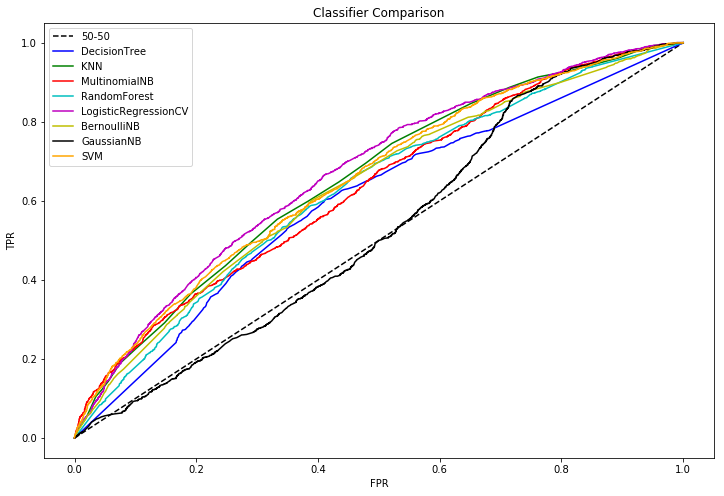

In [11]:
# Plot the ROC curve from the last K-Fold split
fig, ax = plt.subplots(figsize=(12, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange']

# Plot 50-50 Line
ax.plot([0,1],[0,1], ls='--', color='k', label='50-50')
# Plot Classifier ROC Curves
for key, c in zip(roc.keys(), colors):
    ax.plot(roc[key][0], roc[key][1], color=c, label=key)
    
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('Classifier Comparison')
ax.legend(loc='best')
plt.savefig('charts/roc.png')

In [12]:
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py

# n_estimator = 10
# # X, y = make_classification(n_samples=80000)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
# # It is important to train the ensemble of trees on a different subset
# # of the training data than the linear regression model to avoid
# # overfitting, in particular if the total number of leaves is
# # similar to the number of training samples
# X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
#                                                             y_train,
#                                                             test_size=0.5)

# # Unsupervised transformation based on totally random trees
# rt = RandomTreesEmbedding(max_depth=3, n_estimators=n_estimator,
#     random_state=0)

# rt_lm = LogisticRegression()
# pipeline = make_pipeline(rt, rt_lm)
# pipeline.fit(X_train, y_train)
# y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
# fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)

# # Supervised transformation based on random forests
# rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
# rf_enc = OneHotEncoder()
# rf_lm = LogisticRegression()
# rf.fit(X_train, y_train)
# rf_enc.fit(rf.apply(X_train))
# rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

# y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
# fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

# grd = GradientBoostingClassifier(n_estimators=n_estimator)
# grd_enc = OneHotEncoder()
# grd_lm = LogisticRegression()
# grd.fit(X_train, y_train)
# grd_enc.fit(grd.apply(X_train)[:, :, 0])
# grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

# y_pred_grd_lm = grd_lm.predict_proba(
#     grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
# fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)


# # The gradient boosted model by itself
# y_pred_grd = grd.predict_proba(X_test)[:, 1]
# fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)


# # The random forest model by itself
# y_pred_rf = rf.predict_proba(X_test)[:, 1]
# fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

# plt.figure(1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
# plt.plot(fpr_rf, tpr_rf, label='RF')
# plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
# plt.plot(fpr_grd, tpr_grd, label='GBT')
# plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()

# plt.figure(2)
# plt.xlim(0, 0.2)
# plt.ylim(0.8, 1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
# plt.plot(fpr_rf, tpr_rf, label='RF')
# plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
# plt.plot(fpr_grd, tpr_grd, label='GBT')
# plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()

## Phase 2: Deeper Dive on Select Models

## K-Nearest Neighbors KNN

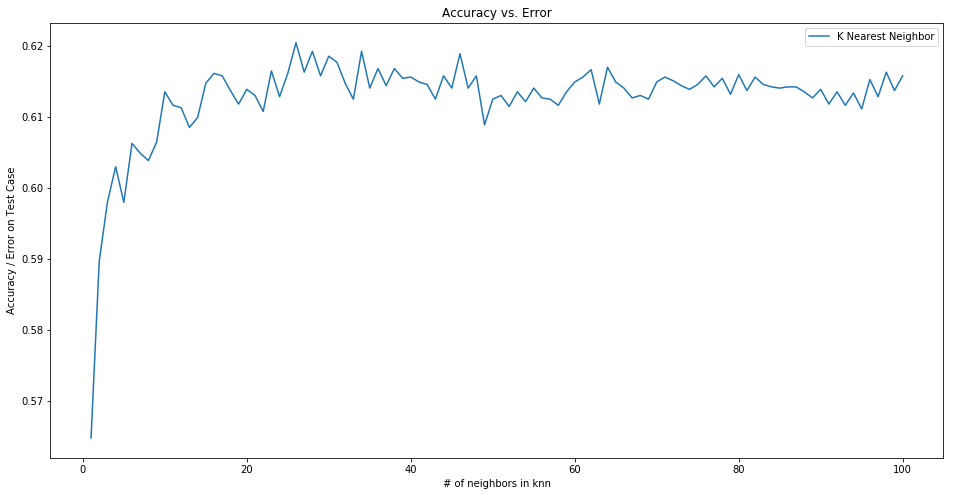

In [13]:
k_acc = []
error_rate = []


for k in k_range:
    knn = KNeighborsClassifier(k)
    knn.fit(X_train_s, y_train)
    pred_k = knn.predict(X_test_s)
    k_acc.append(accuracy_score(y_test, pred_k))
    error_rate.append(np.mean(pred_k != y_test))
    
plt.figure(figsize=(16,8))
plt.plot(k_range, k_acc, '-', label = 'K Nearest Neighbor')
# plt.plot(k_range,error_rate, '-',label = 'Error Rate')
plt.title('Accuracy vs. Error')
plt.xlabel('# of neighbors in knn')
plt.ylabel('Accuracy / Error on Test Case')
plt.legend(loc = 0)

In [14]:
# TO DO get top 5 k values
best_k = k_range[np.argmax(k_acc)]
best_k

26

In [20]:
knn = KNeighborsClassifier(n_neighbors=best_k)

knn.fit(X_train_s,y_train)
pred = knn.predict(X_test_s)

print('WITH Best K')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

WITH Best K


[[2402  875]
 [1322 1189]]


             precision    recall  f1-score   support

          0       0.65      0.73      0.69      3277
          1       0.58      0.47      0.52      2511

avg / total       0.62      0.62      0.61      5788



## Logistic Regression

In [17]:
# vanilla case
logmodel = LogisticRegression()
logmodel.fit(X_train_s,y_train)

predictions = logmodel.predict(X_test_s)
print(classification_report(y_test,predictions))
# logmodel.coef_
logmodel.predict_proba(X_train_s)

             precision    recall  f1-score   support

          0       0.66      0.71      0.68      3277
          1       0.58      0.52      0.55      2511

avg / total       0.62      0.63      0.62      5788



array([[0.52531803, 0.47468197],
       [0.55752422, 0.44247578],
       [0.26976832, 0.73023168],
       ...,
       [0.63592896, 0.36407104],
       [0.58839644, 0.41160356],
       [0.53930518, 0.46069482]])

In [18]:
# vanilla case
logmodel = LogisticRegressionCV()
logmodel.fit(X_train_s,y_train)

predictions = logmodel.predict(X_test_s)
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.66      0.72      0.69      3277
          1       0.59      0.51      0.55      2511

avg / total       0.63      0.63      0.63      5788



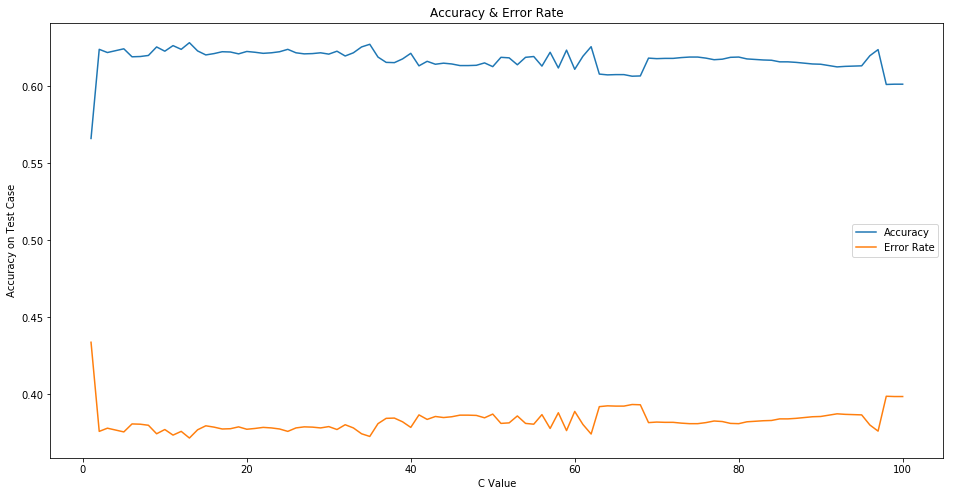

In [22]:
# test range of C values
accuracy = []
error_rate = []


for k in k_range:
    logmodel = LogisticRegressionCV(Cs=k) 
    logmodel.fit(X_train,y_train)
    y_pred = logmodel.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    error_rate.append(np.mean(y_pred != y_test))
    
plt.figure(figsize=(16,8))
plt.plot(k_range, accuracy, '-', label = 'Accuracy')
plt.plot(k_range,error_rate, '-',label = 'Error Rate')
plt.title('Accuracy & Error Rate')
plt.xlabel('C Value')
plt.ylabel('Accuracy on Test Case')
plt.legend(loc = 0)

In [23]:
best_C = k_range[np.argmax(accuracy)]
best_C

13

In [24]:
# print(classification_report(y_test,predictions))

In [27]:
# Plot Training Examples vs. Accuracy
# fig, ax = plt.subplots(figsize=(10, 8))

# plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.1, color="r")
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.1, color="g")
# plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
# plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# ax.set_title('Learning Curves (LogisticRegression)')
# ax.set_xlabel('Training Examples')
# ax.set_ylabel('Accuracy')
# ax.legend(loc='best');

In [28]:
logreg = LogisticRegression()
log_accuracy = cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean()
log_accuracy

0.5662225928643035

In [29]:
train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(), 
                                                        X, y,
                                                        cv=10, 
                                                        scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

In [30]:
# predictions = logmodel.predict(X_test)

In [31]:
# print(classification_report(y_test,predictions))

## SVM

In [32]:
svc_model = SVC()

In [33]:
svc_model.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [34]:
predictions = svc_model.predict(X_test)

In [35]:
print(confusion_matrix(y_test,predictions))

[[2493  784]
 [1622  889]]


In [36]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.61      0.76      0.67      3277
          1       0.53      0.35      0.42      2511

avg / total       0.57      0.58      0.57      5788



## Decision Trees

In [37]:
dtree = DecisionTreeClassifier()

In [38]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [39]:
predictions = dtree.predict(X_test)

In [40]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.63      0.71      0.66      3277
          1       0.54      0.45      0.49      2511

avg / total       0.59      0.60      0.59      5788



In [41]:
print(confusion_matrix(y_test,predictions))

[[2315  962]
 [1373 1138]]


## Random Forest

In [42]:
rfc = RandomForestClassifier(n_estimators=600)

In [43]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [44]:
predictions = rfc.predict(X_test)

In [45]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.64      0.70      0.67      3277
          1       0.55      0.48      0.52      2511

avg / total       0.60      0.61      0.60      5788



In [46]:
print(confusion_matrix(y_test,predictions))

[[2298  979]
 [1297 1214]]


In [48]:
pipeline = make_pipeline(StandardScaler(), 
                         RandomForestRegressor(n_estimators=100))

In [50]:
pipeline

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

## Naive Bayes

In [51]:
model = naive_bayes.GaussianNB()
model.fit(X_train, y_train)

print("Accuracy: %.3f"% accuracy_score(y_test, model.predict(X_test)))
print(classification_report(y_test, model.predict(X_test)))

Accuracy: 0.466
             precision    recall  f1-score   support

          0       0.82      0.07      0.13      3277
          1       0.45      0.98      0.61      2511

avg / total       0.66      0.47      0.34      5788



In [52]:
model = naive_bayes.BernoulliNB()
model.fit(X_train, y_train)

print("Accuracy: %.3f"% accuracy_score(y_test, model.predict(X_test)))
print(classification_report(y_test, model.predict(X_test)))

Accuracy: 0.607
             precision    recall  f1-score   support

          0       0.64      0.69      0.67      3277
          1       0.55      0.50      0.52      2511

avg / total       0.60      0.61      0.60      5788



In [53]:
model = naive_bayes.MultinomialNB()
model.fit(X_train, y_train)

print("Accuracy: %.3f"% accuracy_score(y_test, model.predict(X_test)))
print(classification_report(y_test, model.predict(X_test)))


Accuracy: 0.530
             precision    recall  f1-score   support

          0       0.74      0.26      0.38      3277
          1       0.48      0.88      0.62      2511

avg / total       0.63      0.53      0.49      5788



In [54]:
X_train = scale(X_train)
X_test = scale(X_test)

model = LinearSVC()
model.fit(X_train, y_train)

print("Accuracy: %.3f"% accuracy_score(y_test, model.predict(X_test)))
print(classification_report(y_test, model.predict(X_test)))

Accuracy: 0.619
             precision    recall  f1-score   support

          0       0.67      0.64      0.66      3277
          1       0.56      0.59      0.57      2511

avg / total       0.62      0.62      0.62      5788



In [55]:
model = SVC()
model.fit(X_train, y_train)

print("Accuracy: %.3f"% accuracy_score(y_test, model.predict(X_test)))
print(classification_report(y_test, model.predict(X_test)))

Accuracy: 0.612
             precision    recall  f1-score   support

          0       0.66      0.66      0.66      3277
          1       0.55      0.55      0.55      2511

avg / total       0.61      0.61      0.61      5788



## Gradient Boosting

## Ensemble

## Classification Errors

In [56]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [57]:
# Find the weighted precision and recall
print('Weighted Precision:', precision_score(y_test, y_pred, average='weighted'))
print('Weighted Recall:', recall_score(y_test, y_pred, average='weighted'))

Weighted Precision: 0.6269844480463977
Weighted Recall: 0.6290601243953006


In [58]:
print(classification_report(y_test, y_pred)) #, target_names=target_names))

             precision    recall  f1-score   support

          0       0.67      0.69      0.68      3277
          1       0.58      0.55      0.56      2511

avg / total       0.63      0.63      0.63      5788



In [59]:
logreg = OneVsRestClassifier(LogisticRegression())
logreg.fit(X_train, y_train)
y_score = logreg.decision_function(X_test)

In [60]:
print('Micro Average Precision:', average_precision_score(y_test, y_score, average='micro'))
print('Macro Average Precision:', average_precision_score(y_test, y_score, average='macro'))
print('Weighted Average Precision:', average_precision_score(y_test, y_score, average='weighted'))
print('Precision for each Class:', average_precision_score(y_test, y_score, average=None))

Micro Average Precision: 0.584315375417109
Macro Average Precision: 0.584315375417109
Weighted Average Precision: 0.584315375417109
Precision for each Class: 0.584315375417109


In [61]:
precision, recall, _ = precision_recall_curve(y_test.ravel(), y_score.ravel())

In [62]:
precision

array([0.43738025, 0.43726037, 0.43716228, ..., 0.5       , 0.        ,
       1.        ])

In [63]:
recall

array([1.00000000e+00, 9.99203505e-01, 9.98805257e-01, ...,
       3.98247710e-04, 0.00000000e+00, 0.00000000e+00])

In [64]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy_score(y_test, y_pred)

0.6290601243953006

In [66]:
# y_score = logreg.predict_proba(X_test)[:,1]
# # print(y_score)
# # print(y_test)
# fpr, tpr, _ = roc_curve(y_test, y_score)
# # print(fpr)
# # print(tpr)
# roc_auc = auc([fpr, tpr])

In [68]:
# fig, ax = plt.subplots(figsize=(12, 8))

# # Plot 50-50 Line
# ax.plot([0,1],[0,1], ls='--', color='k', label='50-50')
# # Plot Logistic ROC curve
# ax.plot(fpr, tpr, color='b', label='Logistic: %.3f' % roc_auc)
    
# ax.set_xlabel('FPR')
# ax.set_ylabel('TPR')
# ax.set_title('Logistic ROC Curve')
# ax.legend(loc='best');

## GridSearchCV

In [ ]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] kernel=linear, C=1 ..............................................
[CV] ............................... kernel=linear, C=1, total=  19.6s
[CV] kernel=linear, C=1 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.0s remaining:    0.0s


[CV] ............................... kernel=linear, C=1, total=  12.8s
[CV] kernel=linear, C=1 ..............................................
[CV] ............................... kernel=linear, C=1, total=  13.0s
[CV] kernel=linear, C=10 .............................................


In [ ]:
grid_predictions = grid.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))